### Lab2 (a) Model preperation

In [2]:
from resnet20 import ResNetCIFAR
from train_util import train, finetune, test
import torch
import numpy as np
import matplotlib.pyplot as plt

import time

import torchvision.transforms as transforms
import torchvision
import torch.nn as nn
import torch.optim as optim

from FP_layers import *

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
net = ResNetCIFAR(num_layers=20, Nbits=None)
net = net.to(device)

In [3]:
# Load the best weight paramters
net.load_state_dict(torch.load("pretrained_model.pt"))
test(net)

Files already downloaded and verified
Test Loss=0.3231, Test accuracy=0.9150


0.915

### Lab2 (b) Prune by percentage

In [4]:
def prune_by_percentage(layer, q):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    with torch.no_grad():
        # Convert the weight of "layer" to numpy array
        layer_weight = layer.weight.detach().cpu().numpy()
        # Compute the q-th percentile of the abs of the converted array
        percentile = np.percentile(np.abs(layer_weight.flatten()), q)
        # Generate a binary mask same shape as weight to decide which element to prune
        masked_obj = np.ma.masked_greater_equal(x=np.abs(layer_weight), value=percentile, copy=True)
        mask_int = np.ma.getmask(masked_obj).astype(int)
        # Convert mask to torch tensor and put on GPU
        mask_tensor = torch.tensor(mask_int).to(device)
        # Multiply the weight by mask to perform pruning
        assert mask_int.shape == layer_weight.shape
        # layer.weight.data = mask_tensor * layer.weight.data
        layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * mask_tensor
    return
    

In [5]:
q_list = np.array([0.3, 0.5, 0.7]) * 100

test_acc_prune_by_perc = []

for q_val in q_list:
    net.load_state_dict(torch.load("pretrained_model.pt"))
    for name, layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # change q value
            prune_by_percentage(layer, q=q_val)
            # break
            ## Optional: Check the sparsity you achieve in each layer
            ## Convert the weight of "layer" to numpy array
            np_weight = layer.weight.detach().cpu().numpy()
            ## Count number of zeros
            zeros = sum((np_weight == 0).flatten())
            ## Count number of parameters
            total = len(np_weight.flatten())
            ## Print sparsity
            # print('Sparsity of ' + name + ': '+ str(zeros/total))
            print('Sparsity of %s: %g' % (name, zeros/total))
    test_acc_prune_by_perc.append(test(net))

Sparsity of head_conv.0.conv: 0.300926
Sparsity of body_op.0.conv1.0.conv: 0.299913
Sparsity of body_op.0.conv2.0.conv: 0.299913
Sparsity of body_op.1.conv1.0.conv: 0.299913
Sparsity of body_op.1.conv2.0.conv: 0.299913
Sparsity of body_op.2.conv1.0.conv: 0.299913
Sparsity of body_op.2.conv2.0.conv: 0.299913
Sparsity of body_op.3.conv1.0.conv: 0.30013
Sparsity of body_op.3.conv2.0.conv: 0.300022
Sparsity of body_op.4.conv1.0.conv: 0.300022
Sparsity of body_op.4.conv2.0.conv: 0.300022
Sparsity of body_op.5.conv1.0.conv: 0.300022
Sparsity of body_op.5.conv2.0.conv: 0.300022
Sparsity of body_op.6.conv1.0.conv: 0.300022
Sparsity of body_op.6.conv2.0.conv: 0.299995
Sparsity of body_op.7.conv1.0.conv: 0.299995
Sparsity of body_op.7.conv2.0.conv: 0.299995
Sparsity of body_op.8.conv1.0.conv: 0.299995
Sparsity of body_op.8.conv2.0.conv: 0.299995
Sparsity of final_fc.linear: 0.3
Files already downloaded and verified
Test Loss=0.3699, Test accuracy=0.9027
Sparsity of head_conv.0.conv: 0.5
Sparsity

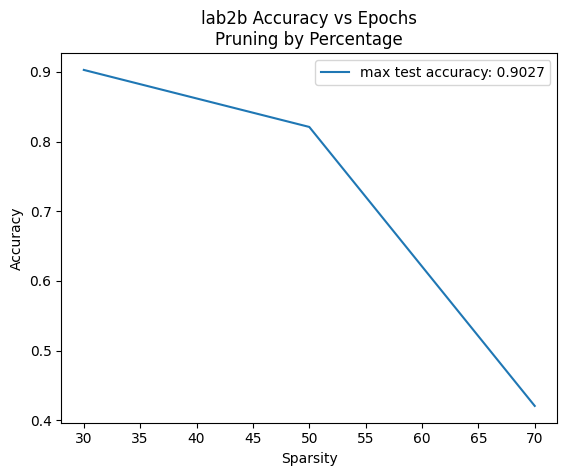

In [39]:
fig, ax = plt.subplots(1, 1)
ax.plot(q_list, test_acc_prune_by_perc, label='max test accuracy: %g' % np.max(test_acc_prune_by_perc))
ax.set_xlabel('Sparsity')
ax.set_ylabel('Accuracy')
ax.set_title('lab2b Accuracy vs Epochs\nPruning by Percentage')
ax.legend()

plt.savefig('lab2b.pdf', dpi=500, bbox_inches='tight')

### Lab2 (c) Finetune pruned model

In [7]:
def finetune_after_prune(net, trainloader, criterion, optimizer, prune=True):
    """
    Finetune the pruned model for a single epoch
    Make sure pruned weights are kept as zero
    """
    # Build a dictionary for the nonzero weights
    weight_mask = {}
    for name, layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Your code here: generate a mask in GPU torch tensor to have 1 for nonzero element and 0 for zero element 
            layer_weight = layer.weight.detach().cpu().numpy()
            mask_obj = np.ma.masked_equal(x=layer_weight, value=0)  # where it's zero, mask value is True
            weight_mask[name] = torch.tensor(1 - np.ma.getmask(mask_obj).astype(int)).to(device)  
            # zero = 0, nonzero = 1
    
    global_steps = 0
    train_loss = 0
    correct = 0
    total = 0
    start = time.time()
    for batch_idx, (inputs, targets) in enumerate(trainloader):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        if prune:
            for name,layer in net.named_modules():
                if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                    # Your code here: Use weight_mask to make sure zero elements remains zero                    
                    layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * weight_mask[name]
                    
        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        global_steps += 1

        if global_steps % 50 == 0:
            end = time.time()
            batch_size = 256
            num_examples_per_second = 50 * batch_size / (end - start)
            print("[Step=%d]\tLoss=%.4f\tacc=%.4f\t%.1f examples/second"
                 % (global_steps, train_loss / (batch_idx + 1), (correct / total), num_examples_per_second))
            start = time.time()

In [8]:
# Get pruned model
net.load_state_dict(torch.load("pretrained_model.pt"))
for name, layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        prune_by_percentage(layer, q=70.0)

# Training setup, do not change
batch_size = 256
lr = 0.002
reg = 1e-4

print('==> Preparing data..')
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
best_acc = 0  # best test accuracy
start_epoch = 0  # start from epoch 0 or last checkpoint epoch
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=16)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=100, shuffle=False, num_workers=2)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.875, weight_decay=reg, nesterov=False)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified


In [10]:
# Model finetuning
test_acc_lst = []
n_epochs = 20
for epoch in range(n_epochs):
    print('\nEpoch: %d' % epoch)
    net.train()
    finetune_after_prune(net, trainloader, criterion, optimizer)
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    test_acc_lst.append(val_acc)
    if val_acc > best_acc:
        best_acc = val_acc
        print("Saving...")
        torch.save(net.state_dict(), "net_after_finetune.pt")


Epoch: 0
[Step=50]	Loss=0.1424	acc=0.9499	6760.8 examples/second
[Step=100]	Loss=0.1452	acc=0.9493	12308.8 examples/second
[Step=150]	Loss=0.1443	acc=0.9496	12569.8 examples/second
Test Loss=0.3366, Test acc=0.8943
Saving...

Epoch: 1
[Step=50]	Loss=0.1511	acc=0.9492	6221.0 examples/second
[Step=100]	Loss=0.1469	acc=0.9499	11427.6 examples/second
[Step=150]	Loss=0.1437	acc=0.9508	11413.2 examples/second
Test Loss=0.3329, Test acc=0.8948
Saving...

Epoch: 2
[Step=50]	Loss=0.1405	acc=0.9522	6565.2 examples/second
[Step=100]	Loss=0.1397	acc=0.9523	12612.8 examples/second
[Step=150]	Loss=0.1390	acc=0.9531	12663.7 examples/second
Test Loss=0.3339, Test acc=0.8967
Saving...

Epoch: 3
[Step=50]	Loss=0.1376	acc=0.9534	6359.6 examples/second
[Step=100]	Loss=0.1392	acc=0.9520	12186.0 examples/second
[Step=150]	Loss=0.1384	acc=0.9513	12331.6 examples/second
Test Loss=0.3335, Test acc=0.8957

Epoch: 4
[Step=50]	Loss=0.1355	acc=0.9527	6401.6 examples/second
[Step=100]	Loss=0.1350	acc=0.9541	12506.

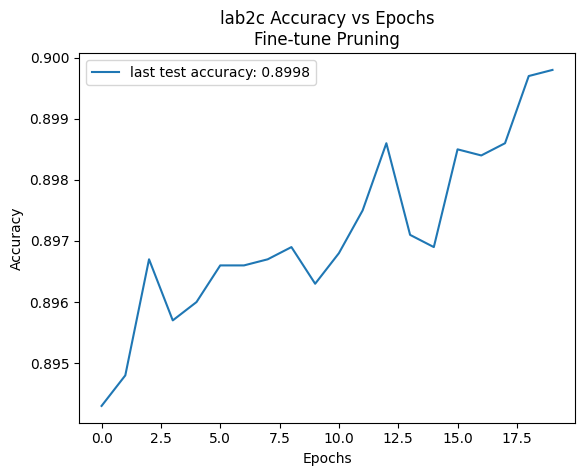

In [40]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_lst, label='last test accuracy: %g' % test_acc_lst[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2c Accuracy vs Epochs\nFine-tune Pruning')
ax.legend()

plt.savefig('lab2c.pdf', dpi=500, bbox_inches='tight')

In [12]:
# Check sparsity of the finetuned model, make sure it's not changed
net.load_state_dict(torch.load("net_after_finetune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        ## Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        ## Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        ## Count number of parameters
        total = len(np_weight.flatten())
        # Print sparsity
        print('Sparsity of %s: %g' % (name, zeros/total))   
        
test(net)

Sparsity of head_conv.0.conv: 0.699074
Sparsity of body_op.0.conv1.0.conv: 0.700087
Sparsity of body_op.0.conv2.0.conv: 0.700087
Sparsity of body_op.1.conv1.0.conv: 0.700087
Sparsity of body_op.1.conv2.0.conv: 0.700087
Sparsity of body_op.2.conv1.0.conv: 0.700087
Sparsity of body_op.2.conv2.0.conv: 0.700087
Sparsity of body_op.3.conv1.0.conv: 0.69987
Sparsity of body_op.3.conv2.0.conv: 0.699978
Sparsity of body_op.4.conv1.0.conv: 0.699978
Sparsity of body_op.4.conv2.0.conv: 0.699978
Sparsity of body_op.5.conv1.0.conv: 0.699978
Sparsity of body_op.5.conv2.0.conv: 0.699978
Sparsity of body_op.6.conv1.0.conv: 0.699978
Sparsity of body_op.6.conv2.0.conv: 0.700005
Sparsity of body_op.7.conv1.0.conv: 0.700005
Sparsity of body_op.7.conv2.0.conv: 0.700005
Sparsity of body_op.8.conv1.0.conv: 0.700005
Sparsity of body_op.8.conv2.0.conv: 0.700005
Sparsity of final_fc.linear: 0.7
Files already downloaded and verified
Test Loss=0.3304, Test accuracy=0.8998


0.8998

### Lab2 (d) Iterative pruning

In [13]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.
n_epochs = 20

test_acc_iter_prune = []

for epoch in range(n_epochs):
    print('\nEpoch: %d' % epoch)
    
    net.train()
    if epoch < 10:
        for name,layer in net.named_modules():
            if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
                # Increase model sparsity
                q = (epoch + 1) * 7
                # Linearly increase the pruning percentage for 10 epochs until reaching 70% in the final epoch
                prune_by_percentage(layer, q=q)
    if epoch < 9:
        finetune_after_prune(net, trainloader, criterion, optimizer, prune=False)
    else: # starts from epoch==9, where q = 70%
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    
    test_acc_iter_prune.append(val_acc)
        
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    
    if epoch>=10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0497	acc=0.9845	6557.1 examples/second
[Step=100]	Loss=0.0493	acc=0.9847	12587.0 examples/second
[Step=150]	Loss=0.0471	acc=0.9858	12324.3 examples/second
Test Loss=0.3277, Test acc=0.9147

Epoch: 1
[Step=50]	Loss=0.0484	acc=0.9849	6465.8 examples/second
[Step=100]	Loss=0.0482	acc=0.9850	12568.8 examples/second
[Step=150]	Loss=0.0485	acc=0.9846	12813.9 examples/second
Test Loss=0.3268, Test acc=0.9144

Epoch: 2
[Step=50]	Loss=0.0502	acc=0.9841	6545.6 examples/second
[Step=100]	Loss=0.0492	acc=0.9851	12856.8 examples/second
[Step=150]	Loss=0.0499	acc=0.9847	12765.8 examples/second
Test Loss=0.3286, Test acc=0.9144

Epoch: 3
[Step=50]	Loss=0.0541	acc=0.9829	6295.5 examples/second
[Step=100]	Loss=0.0516	acc=0.9834	12339.3 examples/second
[Step=150]	Loss=0.0510	acc=0.9838	12356.7 examples/second
Test Loss=0.3285, Test acc=0.9139

Epoch: 4
[Step=50]	Loss=0.0608	acc=0.9796	6708.1 examples/second
[Step=100]	Loss=0.0610	acc=0.9800	12388.0 examples/second
[Step=150]	L

In [14]:
# Check sparsity of the final model, make sure it's 70%
net.load_state_dict(torch.load("net_after_iterative_prune.pt"))

for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here: can copy from previous question
        ## Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        ## Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        ## Count number of parameters
        total = len(np_weight.flatten())
        # Print sparsity
        print('Sparsity of %s: %g' % (name, zeros/total))   
        
        
test(net)

Sparsity of head_conv.0.conv: 0.699074
Sparsity of body_op.0.conv1.0.conv: 0.700087
Sparsity of body_op.0.conv2.0.conv: 0.700087
Sparsity of body_op.1.conv1.0.conv: 0.700087
Sparsity of body_op.1.conv2.0.conv: 0.700087
Sparsity of body_op.2.conv1.0.conv: 0.700087
Sparsity of body_op.2.conv2.0.conv: 0.700087
Sparsity of body_op.3.conv1.0.conv: 0.69987
Sparsity of body_op.3.conv2.0.conv: 0.699978
Sparsity of body_op.4.conv1.0.conv: 0.699978
Sparsity of body_op.4.conv2.0.conv: 0.699978
Sparsity of body_op.5.conv1.0.conv: 0.699978
Sparsity of body_op.5.conv2.0.conv: 0.699978
Sparsity of body_op.6.conv1.0.conv: 0.699978
Sparsity of body_op.6.conv2.0.conv: 0.700005
Sparsity of body_op.7.conv1.0.conv: 0.700005
Sparsity of body_op.7.conv2.0.conv: 0.700005
Sparsity of body_op.8.conv1.0.conv: 0.700005
Sparsity of body_op.8.conv2.0.conv: 0.700005
Sparsity of final_fc.linear: 0.7
Files already downloaded and verified
Test Loss=0.3420, Test accuracy=0.8909


0.8909

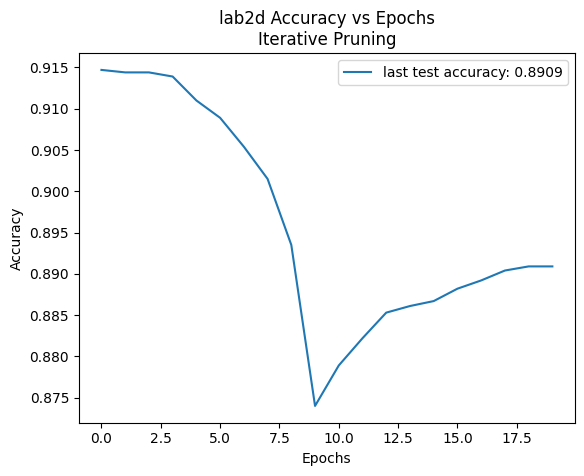

In [41]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_iter_prune, label='last test accuracy: %g' % test_acc_iter_prune[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2d Accuracy vs Epochs\nIterative Pruning')
ax.legend()

plt.savefig('lab2d.pdf', dpi=500, bbox_inches='tight')

### Lab2 (e) Global iterative pruning

In [29]:
import numpy as np

def global_prune_by_percentage(net, q=70.0):
    """
    Pruning the weight paramters by threshold.
    :param q: pruning percentile. 'q' percent of the least 
    significant weight parameters will be pruned.
    """
    # A list to gather all the weights
    flattened_weights = []
    # Find global pruning threshold
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            # Flatten the weight and append to flattened_weights
            flattened_weights.append(layer.weight.detach().cpu().numpy().flatten())
    
    # Concate all weights into a np array
    flattened_weights = np.concatenate(flattened_weights)
    # Find global pruning threshold
    threshold = np.percentile(np.abs(flattened_weights.flatten()), q)
    
    # Apply pruning threshold to all layers
    for name,layer in net.named_modules():
        if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
            # Convert weight to numpy
            layer_weight = layer.weight.detach().cpu().numpy()
            
            # Generate a binary mask same shape as weight to decide which element to prune
            masked_obj = np.ma.masked_greater_equal(x=np.abs(layer_weight), value=threshold, copy=True)
            mask_int = np.ma.getmask(masked_obj).astype(int)
            # Convert mask to torch tensor and put on GPU
            mask_tensor = torch.tensor(mask_int).to(device)
            # Multiply the weight by mask to perform pruning
            layer.weight.data = layer.weight.data.clone().detach().requires_grad_(True) * mask_tensor

In [30]:
net.load_state_dict(torch.load("pretrained_model.pt"))
best_acc = 0.

test_acc_global_prune = []

for epoch in range(20):
    print('\nEpoch: %d' % epoch)
    # q = (epoch + 1) * 8
    q = (epoch + 1) * 7
    
    net.train()
    # Increase model sparsity
    if epoch < 10:
        global_prune_by_percentage(net, q=q)
    if epoch < 9:
        finetune_after_prune(net, trainloader, criterion, optimizer, prune=False)
    else:
        finetune_after_prune(net, trainloader, criterion, optimizer)
    
    #Start the testing code.
    net.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(testloader):
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = net(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    num_val_steps = len(testloader)
    val_acc = correct / total
    print("Test Loss=%.4f, Test acc=%.4f" % (test_loss / (num_val_steps), val_acc))
    
    test_acc_global_prune.append(val_acc)
    
    if epoch >= 10:
        if val_acc > best_acc:
            best_acc = val_acc
            print("Saving...")
            torch.save(net.state_dict(), "net_after_global_iterative_prune.pt")


Epoch: 0
[Step=50]	Loss=0.0465	acc=0.9859	6434.4 examples/second
[Step=100]	Loss=0.0468	acc=0.9859	12476.3 examples/second
[Step=150]	Loss=0.0480	acc=0.9854	12343.1 examples/second
Test Loss=0.3237, Test acc=0.9140

Epoch: 1
[Step=50]	Loss=0.0458	acc=0.9855	6504.9 examples/second
[Step=100]	Loss=0.0489	acc=0.9848	12626.6 examples/second
[Step=150]	Loss=0.0498	acc=0.9845	12737.6 examples/second
Test Loss=0.3253, Test acc=0.9146

Epoch: 2
[Step=50]	Loss=0.0485	acc=0.9852	6377.0 examples/second
[Step=100]	Loss=0.0491	acc=0.9849	12722.9 examples/second
[Step=150]	Loss=0.0493	acc=0.9846	12549.5 examples/second
Test Loss=0.3261, Test acc=0.9149

Epoch: 3
[Step=50]	Loss=0.0524	acc=0.9834	6620.0 examples/second
[Step=100]	Loss=0.0516	acc=0.9830	12695.3 examples/second
[Step=150]	Loss=0.0516	acc=0.9833	12712.3 examples/second
Test Loss=0.3274, Test acc=0.9132

Epoch: 4
[Step=50]	Loss=0.0522	acc=0.9839	6694.8 examples/second
[Step=100]	Loss=0.0529	acc=0.9838	12683.5 examples/second
[Step=150]	L

In [33]:
net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))

zeros_sum = 0
total_sum = 0
for name,layer in net.named_modules():
    if (isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear)) and 'id_mapping' not in name:
        # Your code here:
        # Convert the weight of "layer" to numpy array
        np_weight = layer.weight.detach().cpu().numpy()
        # Count number of zeros
        zeros = sum((np_weight == 0).flatten())
        # Count number of parameters
        total = len(np_weight.flatten())
        zeros_sum += zeros
        total_sum += total
        print('Sparsity of %s: %g' % (name, zeros/ (total / 1.0)))   
print('Total sparsity: %g' % (zeros_sum/(total_sum  / 1.0)))
test(net)

Sparsity of head_conv.0.conv: 0.243056
Sparsity of body_op.0.conv1.0.conv: 0.550781
Sparsity of body_op.0.conv2.0.conv: 0.528646
Sparsity of body_op.1.conv1.0.conv: 0.518663
Sparsity of body_op.1.conv2.0.conv: 0.553385
Sparsity of body_op.2.conv1.0.conv: 0.517795
Sparsity of body_op.2.conv2.0.conv: 0.565104
Sparsity of body_op.3.conv1.0.conv: 0.525174
Sparsity of body_op.3.conv2.0.conv: 0.582574
Sparsity of body_op.4.conv1.0.conv: 0.616211
Sparsity of body_op.4.conv2.0.conv: 0.676432
Sparsity of body_op.5.conv1.0.conv: 0.611545
Sparsity of body_op.5.conv2.0.conv: 0.702691
Sparsity of body_op.6.conv1.0.conv: 0.615126
Sparsity of body_op.6.conv2.0.conv: 0.651042
Sparsity of body_op.7.conv1.0.conv: 0.662489
Sparsity of body_op.7.conv2.0.conv: 0.718859
Sparsity of body_op.8.conv1.0.conv: 0.748074
Sparsity of body_op.8.conv2.0.conv: 0.937256
Sparsity of final_fc.linear: 0.11875
Total sparsity of: 0.699999
Files already downloaded and verified
Test Loss=0.3148, Test accuracy=0.8995


0.8995

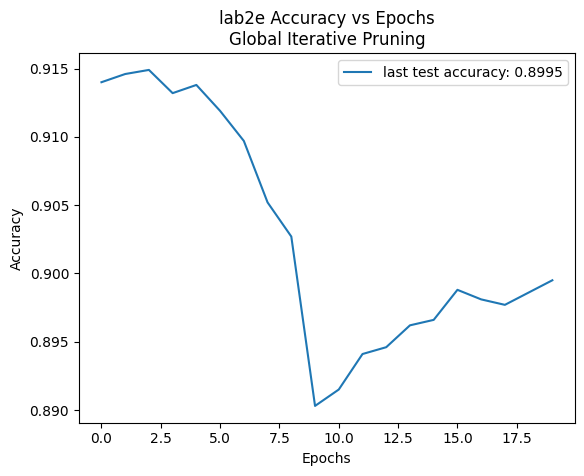

In [42]:
fig, ax = plt.subplots(1, 1)
xx = range(n_epochs)
ax.plot(xx, test_acc_global_prune, label='last test accuracy: %g' % test_acc_global_prune[-1])
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_title('lab2e Accuracy vs Epochs\nGlobal Iterative Pruning')
ax.legend()

plt.savefig('lab2e.pdf', dpi=500, bbox_inches='tight')

### Lab 3 (b) and (c): Fixed-point quantization

In [3]:
# Define quantized model and load weight
Nbits_arr = [2, 3, 4, 5, 6]
test_acc_lab3b = []
for iii, nb in enumerate(Nbits_arr):
    Nbits = nb #Change this value to finish (b) and (c)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test_acc_lab3b.append(test(net))

Files already downloaded and verified
Test Loss=9.6086, Test accuracy=0.0906
Files already downloaded and verified
Test Loss=0.9857, Test accuracy=0.7665
Files already downloaded and verified
Test Loss=0.3860, Test accuracy=0.8973
Files already downloaded and verified
Test Loss=0.3391, Test accuracy=0.9113
Files already downloaded and verified
Test Loss=0.3364, Test accuracy=0.9144


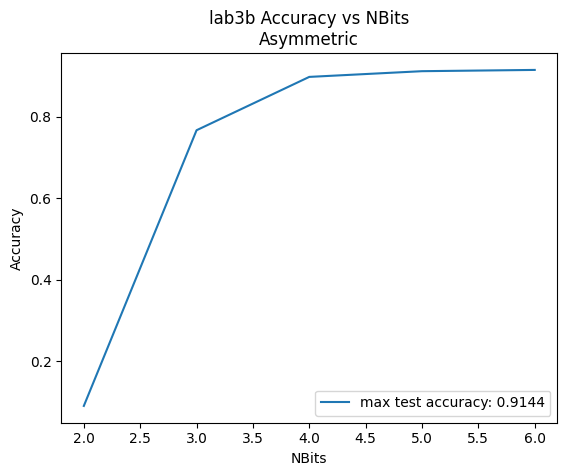

In [4]:
fig, ax = plt.subplots(1, 1)
xx = Nbits_arr
ax.plot(xx, test_acc_lab3b, label='max test accuracy: %g' % np.max(test_acc_lab3b))
ax.set_xlabel('NBits')
ax.set_ylabel('Accuracy')
ax.set_title('lab3b Accuracy vs NBits\nAsymmetric')
ax.legend()

plt.savefig('lab3b.pdf', dpi=500, bbox_inches='tight')

In [2]:
# lab 3 part c is shown below:

In [3]:
Nbits_arr_c = [2, 3, 4]
test_acc_lab3c_finetune = {}
final_test_acc_lab3c = {}
n_epochs = 20
for iii, nb in enumerate(Nbits_arr_c):
    # Define quantized model and load weight
    Nbits = nb #Change this value to finish (b) and (c)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    # net.load_state_dict(torch.load("pretrained_model.pt"))
    # test(net)

    # Quantized model finetuning
    test_acc_lab3c_finetune[Nbits] = np.asarray(
        finetune(net, epochs=n_epochs, batch_size=256, lr=0.002, reg=1e-4)) 
    # finetune() supposedly returns list of val_accuracy values
    # Load the model with best accuracy
    net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    final_test_acc_lab3c[Nbits] = test(net)

==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=1.3362	acc=0.6223	3393.2 examples/second
[Step=100]	Loss=1.0591	acc=0.6850	9283.0 examples/second
[Step=150]	Loss=0.9314	acc=0.7145	9362.7 examples/second
Test Loss=0.7292, Test acc=0.7778
Saving...

Epoch: 1
[Step=200]	Loss=0.5992	acc=0.8193	3257.5 examples/second
[Step=250]	Loss=0.5868	acc=0.8089	9676.1 examples/second
[Step=300]	Loss=0.5685	acc=0.8117	9970.9 examples/second
[Step=350]	Loss=0.5501	acc=0.8163	8536.5 examples/second
Test Loss=0.6525, Test acc=0.8009
Saving...

Epoch: 2
[Step=400]	Loss=0.5241	acc=0.8159	3107.3 examples/second
[Step=450]	Loss=0.4917	acc=0.8327	9377.6 examples/second
[Step=500]	Loss=0.4786	acc=0.8358	8616.9 examples/second
[Step=550]	Loss=0.4735	acc=0.8383	8731.4 examples/second
Test Loss=0.6009, Test acc=0.8185
Saving...

Epoch: 3
[Step=600]	Loss=0.4392	acc=0.8447	3375.9 examples/second
[Step=650]	Loss=0.4215	acc=0.8555	9034.2 example

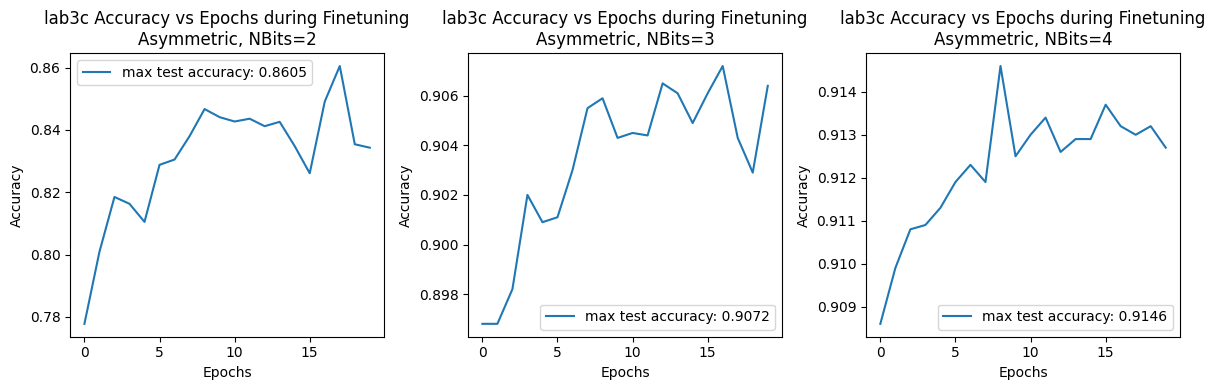

In [11]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for iii, nbits in enumerate(Nbits_arr_c):
    xx = range(n_epochs)
    ax[iii].plot(xx, test_acc_lab3c_finetune[nbits], label='max test accuracy: %g' 
                 % final_test_acc_lab3c[nbits])
    ax[iii].set_xlabel('Epochs')
    ax[iii].set_ylabel('Accuracy')
    ax[iii].set_title('lab3c Accuracy vs Epochs during Finetuning\nAsymmetric, NBits=%d' % nbits)
    ax[iii].legend()
fig.tight_layout()
plt.savefig('lab3c.pdf', dpi=500, bbox_inches='tight')

### Lab3 (d) Quantize pruned model

In [13]:
nbits_lab3d = [2, 3, 4]
test_acc_lab3d_b4_finetune = {}
test_acc_arrays_finetune = {}
test_acc_lab3d_after_finetune = {}
n_epochs = 20

for iii, nb in enumerate(nbits_lab3d):
    # Define quantized model and load weight
    Nbits = nb #Change this value to finish (d)

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits)
    net = net.to(device)
    net.load_state_dict(torch.load("net_after_global_iterative_prune.pt"))
    test_acc_lab3d_b4_finetune[Nbits] = test(net)

    # Quantized model finetuning
    test_acc_arrays_finetune[Nbits] = np.array(
        finetune(net, epochs=n_epochs, batch_size=256, lr=0.002, reg=1e-4))

    # Load the model with best accuracy
    net.load_state_dict(torch.load("quantized_net_after_finetune.pt"))
    test_acc_lab3d_after_finetune[Nbits] = test(net)

Files already downloaded and verified
Test Loss=6706.5256, Test accuracy=0.1000
==> Preparing data..
Files already downloaded and verified
Files already downloaded and verified

Epoch: 0
[Step=50]	Loss=2.2568	acc=0.1452	5483.7 examples/second
[Step=100]	Loss=2.2221	acc=0.1524	8923.8 examples/second
[Step=150]	Loss=2.2023	acc=0.1602	8904.9 examples/second
Test Loss=2.1288, Test acc=0.1796
Saving...

Epoch: 1
[Step=200]	Loss=2.1452	acc=0.1758	3446.4 examples/second
[Step=250]	Loss=2.1321	acc=0.1904	9233.9 examples/second
[Step=300]	Loss=2.1248	acc=0.2001	8992.2 examples/second
[Step=350]	Loss=2.1169	acc=0.2077	8644.7 examples/second
Test Loss=2.0916, Test acc=0.2289
Saving...

Epoch: 2
[Step=400]	Loss=2.0892	acc=0.2119	3355.8 examples/second
[Step=450]	Loss=2.0799	acc=0.2280	9060.7 examples/second
[Step=500]	Loss=2.0772	acc=0.2276	8989.4 examples/second
[Step=550]	Loss=2.0757	acc=0.2302	9354.7 examples/second
Test Loss=2.0701, Test acc=0.2314
Saving...

Epoch: 3
[Step=600]	Loss=2.0506	ac

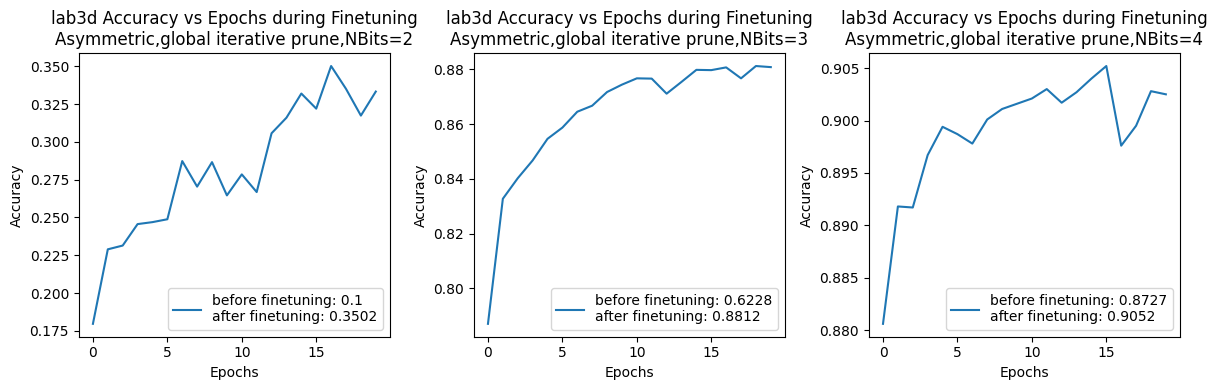

In [14]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

for iii, nbits in enumerate(nbits_lab3d):
    xx = range(n_epochs)
    ax[iii].plot(xx, test_acc_arrays_finetune[nbits], label='before finetuning: %g\nafter finetuning: %g' 
                 % (test_acc_lab3d_b4_finetune[nbits], test_acc_lab3d_after_finetune[nbits]))
    ax[iii].set_xlabel('Epochs')
    ax[iii].set_ylabel('Accuracy')
    ax[iii].set_title('lab3d Accuracy vs Epochs during Finetuning\n'
                      'Asymmetric,global iterative prune,NBits=%d' % nbits)
    ax[iii].legend()
fig.tight_layout()
plt.savefig('lab3d.pdf', dpi=500, bbox_inches='tight')

### Lab3 (e) Symmetric quantization
#### Implement symmetric quantization in FP_layers.py, and repeat the process in (b)

In [15]:
# check the performance of symmetric quantization with 6, 5, 4, 3, 2 bits
# Define quantized model and load weight
Nbits_arr_lab3e = [2, 3, 4, 5, 6]
test_acc_lab3e = []
for iii, nb in enumerate(Nbits_arr_lab3e):
    Nbits = nb #Change this value

    net = ResNetCIFAR(num_layers=20, Nbits=Nbits, symmetric=True)  # symmetric
    net = net.to(device)
    net.load_state_dict(torch.load("pretrained_model.pt"))
    test_acc_lab3e.append(test(net))

Files already downloaded and verified
Test Loss=31.9952, Test accuracy=0.1014
Files already downloaded and verified
Test Loss=2.1068, Test accuracy=0.5995
Files already downloaded and verified
Test Loss=0.3775, Test accuracy=0.8948
Files already downloaded and verified
Test Loss=0.3497, Test accuracy=0.9090
Files already downloaded and verified
Test Loss=0.3339, Test accuracy=0.9128


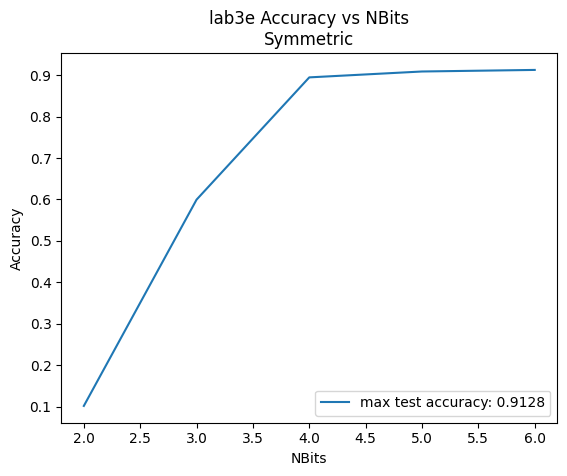

In [16]:
fig, ax = plt.subplots(1, 1)
xx = Nbits_arr_lab3e
ax.plot(xx, test_acc_lab3e, label='max test accuracy: %g' % np.max(test_acc_lab3e))
ax.set_xlabel('NBits')
ax.set_ylabel('Accuracy')
ax.set_title('lab3e Accuracy vs NBits\nSymmetric')
ax.legend()

plt.savefig('lab3e.pdf', dpi=500, bbox_inches='tight')

In [30]:
net = ResNetCIFAR(num_layers=20, Nbits=None, symmetric=False)  # symmetric
net = net.to(device)
net.load_state_dict(torch.load("pretrained_model.pt"))

weights_dict = {}

for name, module in net.named_modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        weights_dict[str(name)] = \
            list((module.weight.cpu().detach().numpy()).flatten())
print(len(weights_dict.keys()))
print(weights_dict.keys())


22
dict_keys(['head_conv.0.conv', 'body_op.0.conv1.0.conv', 'body_op.0.conv2.0.conv', 'body_op.1.conv1.0.conv', 'body_op.1.conv2.0.conv', 'body_op.2.conv1.0.conv', 'body_op.2.conv2.0.conv', 'body_op.3.conv1.0.conv', 'body_op.3.conv2.0.conv', 'body_op.3.id_mapping.0.conv', 'body_op.4.conv1.0.conv', 'body_op.4.conv2.0.conv', 'body_op.5.conv1.0.conv', 'body_op.5.conv2.0.conv', 'body_op.6.conv1.0.conv', 'body_op.6.conv2.0.conv', 'body_op.6.id_mapping.0.conv', 'body_op.7.conv1.0.conv', 'body_op.7.conv2.0.conv', 'body_op.8.conv1.0.conv', 'body_op.8.conv2.0.conv', 'final_fc.linear'])


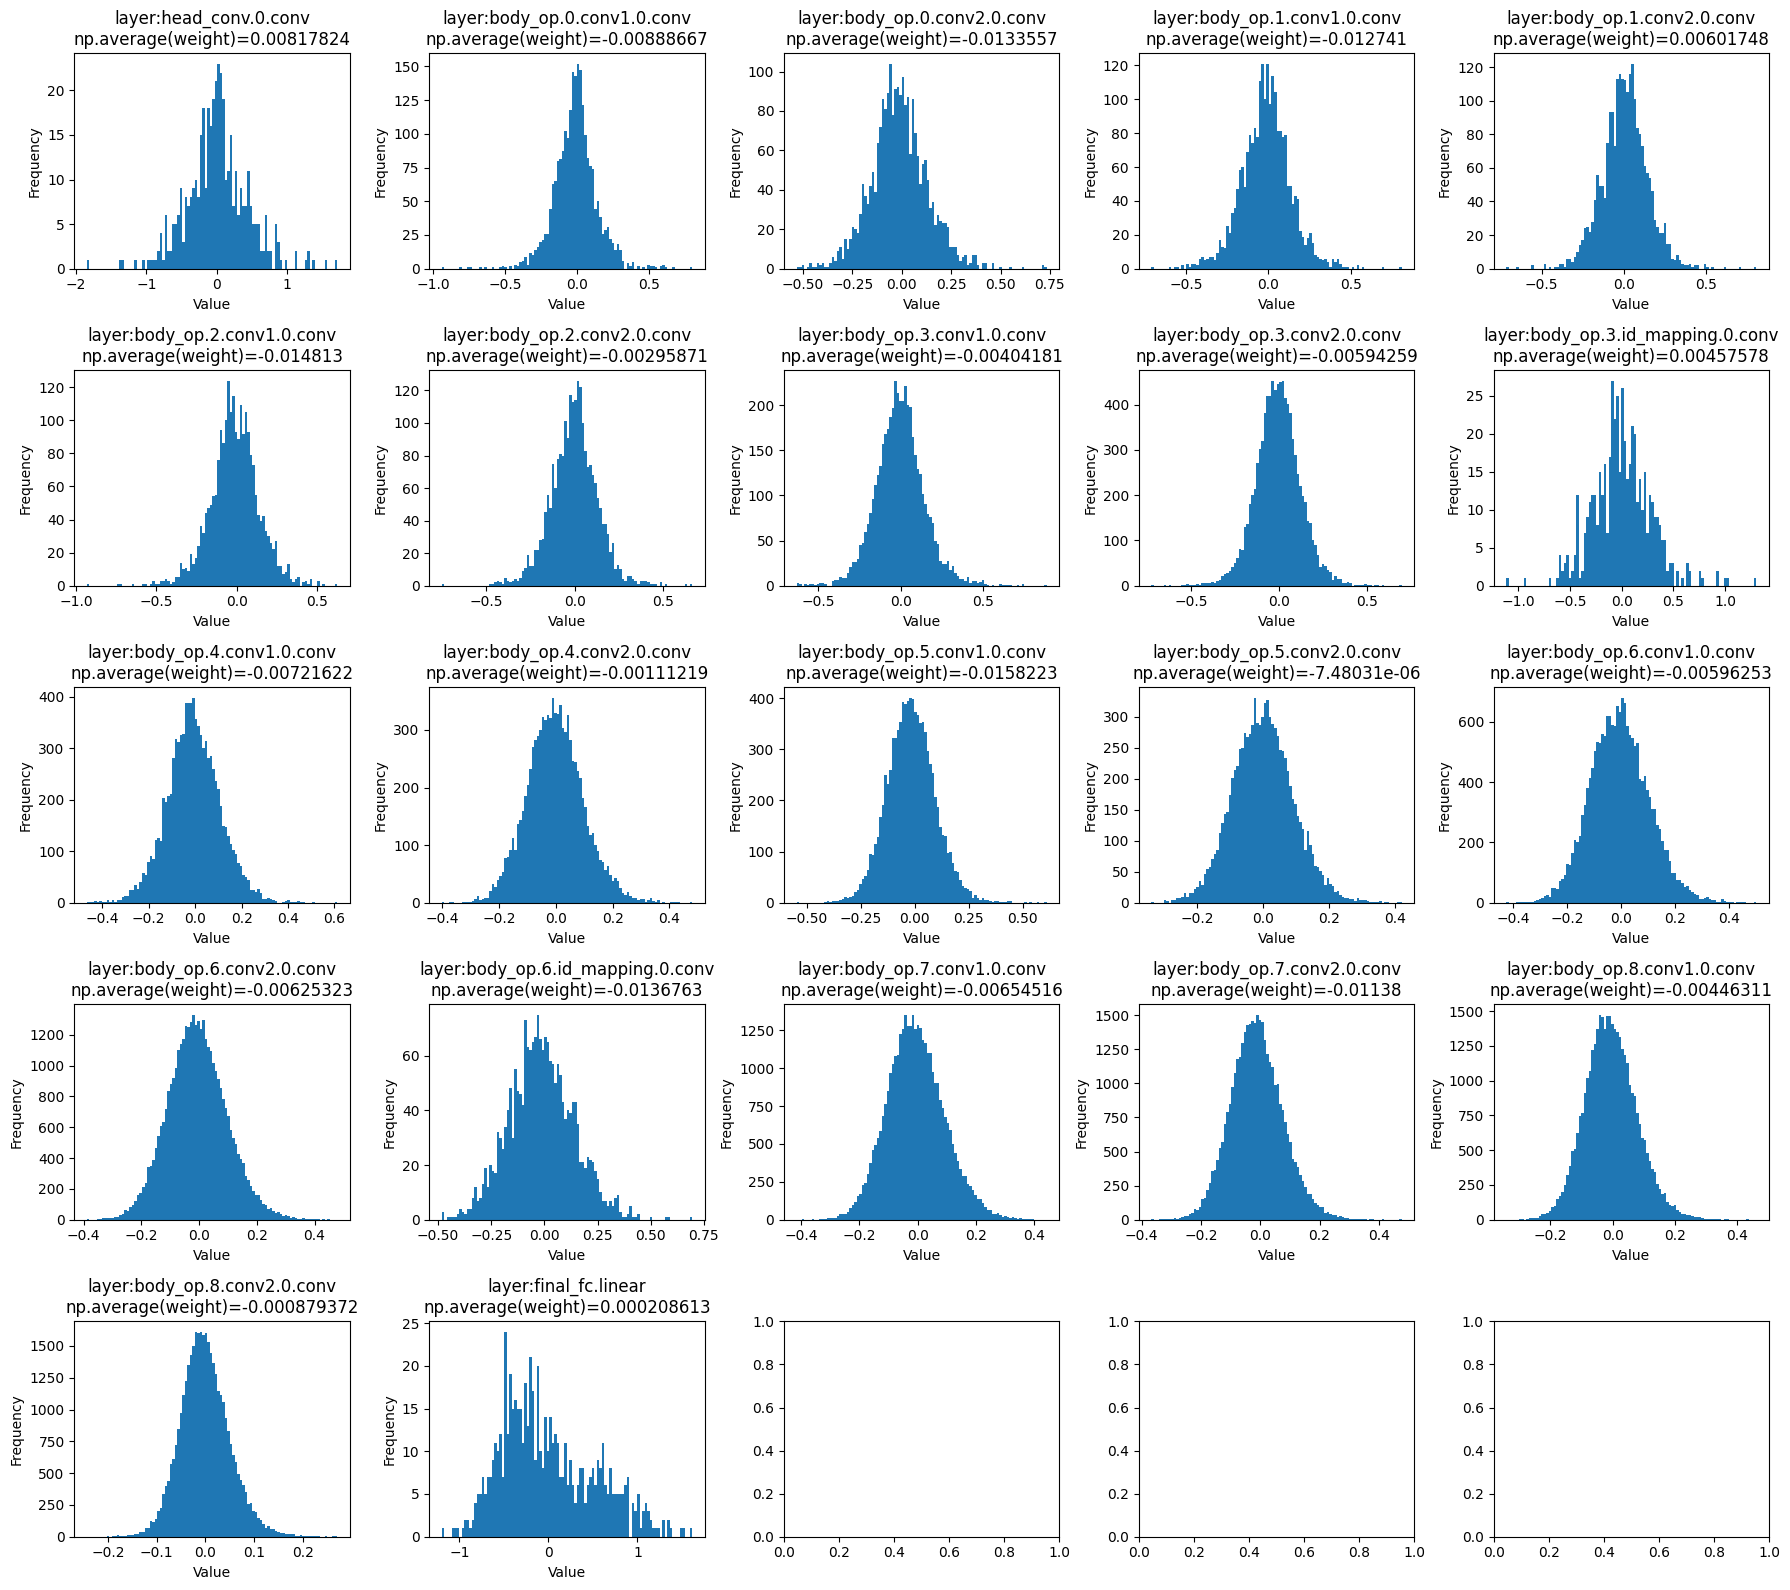

In [35]:
fig, ax = plt.subplots(5, 5, figsize=(18, 16))
ax_flat = ax.flatten()
for iii, layer_name in enumerate(list(weights_dict.keys())):
    ax_flat[iii].hist(weights_dict[layer_name], bins=100)
    ax_flat[iii].set_title(str("layer:%s\nnp.average(weight)=%g" % 
                               (layer_name, np.average(weights_dict[layer_name]))))
    ax_flat[iii].set_xlabel('Value')
    ax_flat[iii].set_ylabel('Frequency')
fig.tight_layout()